In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc

from constants import CONSTS as CS

In [45]:
CS

{'x_lim': array([-10,  10]),
 'y_lim': array([-10,  10]),
 'theta_lim': array([-3.14159265,  3.14159265]),
 'xp_lim': array([-15,  15]),
 'yp_lim': array([-15,  15]),
 'num_waypoints': 10,
 'waypoint_tol': 0.2,
 'wheelbase': 0.335,
 'max_acc': 3,
 'max_steering_angle': 0.5}

In [2]:
wps = np.array([
        [ 8.62844369,  4.89809566,  1.53850753],
        [-3.3128731 , -8.41245037,  0.2807953 ],
        [ 6.42118345,  9.56369873, -0.52140243],
        [-3.55531364, -7.33024669, -0.58341082],
        [-4.72198946, -4.64057374, -1.95494644],
        [-1.21513531, -4.07460913, -1.61876955],
        [-4.51332572,  9.87373577,  0.22790191],
        [-6.26747526, -9.75024744, -1.55346495],
        [ 7.99872313, -0.73949926, -2.41688927],
        [-9.2515838 ,  6.51287078, -0.61068366]
])

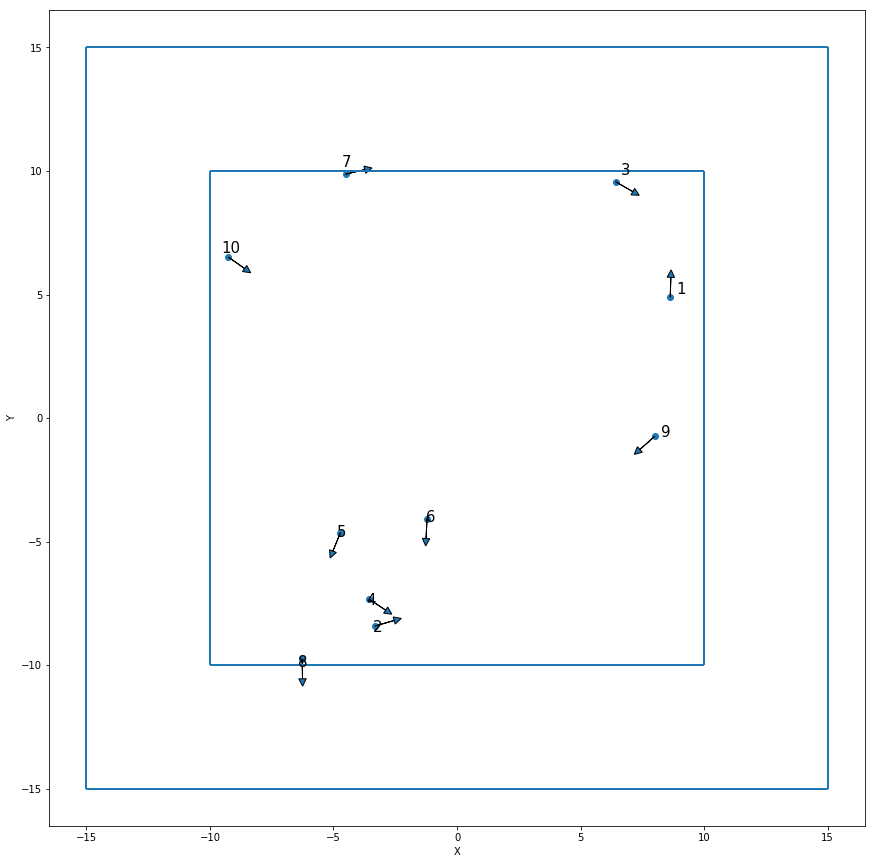

In [52]:
arrow_length = 0.8

plt.figure(figsize=(15, 15))
ax = plt.gca()

plt.scatter(wps[:, 0], wps[:, 1])
for i, wp in enumerate(wps):
    tip = arrow_length * np.array([np.cos(wp[2]), np.sin(wp[2])])
    ax.arrow(wp[0], wp[1], tip[0], tip[1], head_width=0.3, head_length=0.3)
    
    ax.text(wp[0] * 1.03, wp[1] * 1.03, '{}'.format(i + 1), fontsize=15)

lines = [
    [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][0], CS['y_lim'][1])], 
    [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][1], CS['y_lim'][0])], 
    [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][0], CS['y_lim'][1])], 
    [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][1], CS['y_lim'][0])], 
    [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
    [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
    [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
    [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
]
lc = mc.LineCollection(lines, linewidths=2)
ax.add_collection(lc)

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(CS['xp_lim'] * 1.1)
plt.ylim(CS['yp_lim'] * 1.1)

ax.set_aspect('equal')
plt.show()

In [85]:
def cubic_hermite(ts, x0, x1, v0, v1):
    '''
    From https://www.rose-hulman.edu/~finn/CCLI/Notes/day09.pdf
    '''
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = 1 - 3*t2 + 2*t3
    H1 = ts - 2*t2 + t3
    H2 = -t2 + t3
    H3 = 3*t2 - 2*t3
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1

def cubic_hermite_d(ts, x0, x1, v0, v1):
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = - 6*ts + 6*t2
    H1 = np.ones_like(ts) - 4*ts + 3*t2
    H2 = -2*ts + 3*t2
    H3 = 6*ts - 6*t2
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1    

In [115]:
cur_x = np.array([0, 0])
cur_v = np.array([1, 0])

trajs = []
d_trajs = []
speed = 30
n_pts = 20
ts = np.linspace(0, 1, n_pts)

vs = np.c_[np.cos(wps[:,2]), np.sin(wps[:,2])]
for i, wp in enumerate(wps):
    next_x = wp[:2]
    next_v = speed * vs[i]
    
    traj = cubic_hermite(ts, cur_x, next_x, cur_v, next_v)
    trajs.append(traj)
    
    d_traj = cubic_hermite_d(ts, cur_x, next_x, cur_v, next_v)
    d_trajs.append(d_traj)
    
    cur_x, cur_v = next_x, next_v    

trajs = np.array(trajs)
d_trajs = np.array(d_trajs)

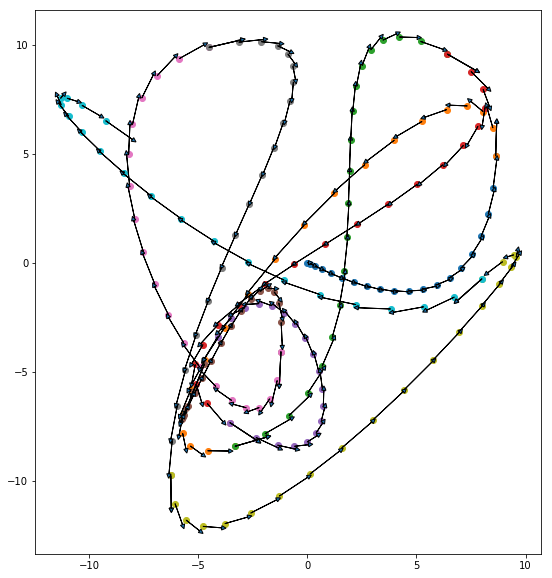

In [116]:
plt.figure(figsize=(10, 10))
ax = plt.gca()

for i, traj in enumerate(trajs):
    plt.scatter(traj[:,0], traj[:,1])
    
    for j, pt in enumerate(traj):
        d_pt = d_trajs[i, j] * 0.05
        ax.arrow(pt[0], pt[1], d_pt[0], d_pt[1], head_width=0.2, head_length=0.2)
    
ax.set_aspect('equal')
plt.show()